# Ethereum Futures vs. ETH & Lido stETH


### Overview

This analysis examines the correlation dynamics between ETH futures and both ETH spot prices and stETH prices across three distinct scenarios. Each scenario explores different timeframes and periods to understand how correlations behave under various market conditions:

- Scenario 1: Explores correlations on a 1-hour timeframe from January 1, 2023, to April 30, 2024, providing a comprehensive view over an extended period to gauge long-term correlation trends.

- Scenario 2: Analyzes the 1-hour timeframe from April 30, 2023, to April 30, 2024, specifically omitting the early 2023 period noted for its lower correlation on stETH. This scenario aims to demonstrate that, excluding this initial volatility, the correlation has remained consistently high and stable.

- Scenario 3: Focuses on a 5-minute timeframe from May 12, 2024, to June 12, 2024, offering insights into the immediate and granular market reactions, highlighting how quickly market dynamics are reflected in pricing correlations.

Visualizations for each scenario provide detailed insights into how closely ETH futures prices track with the spot and stETH markets, enabling a nuanced analysis of market efficiency and price integration across trading platforms and financial instruments.

In [1741]:
# Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Constants
PRICE_CME = 'Price_cme'
PRICE_ETH = 'Price_eth'
PRICE_STETH = 'Price_steth'
PRICE_CME_DELTA = 'Price_cme_delta'
PRICE_CME_PCT = 'Price_cme_return'
PRICE_ETH_DELTA = 'Price_eth_delta'
PRICE_ETH_PCT = 'Price_eth_return'
PRICE_STETH_DELTA = 'Price_steth_delta'
PRICE_STETH_PCT = 'Price_steth_return'

### Functions

In [1742]:
def show_price_old(df):
    """show price over time"""

    plt.figure(figsize=(15, 8))
    plt.plot(df['Entry Date UTC'], df[PRICE_CME], label='ETH Futures Price', color='#1f77b4', linewidth=2)
    plt.plot(df['Entry Date UTC'], df[PRICE_STETH], label='stETH Price', color='#ff7f0e', linewidth=1, alpha=0.6)
    plt.xlabel('Date')
    plt.ylabel('ETH Price ($)')
    plt.title('stETH vs Futures ETH Prices')
    plt.legend()
    plt.show()


In [1743]:
def show_price(df_eth, df_steth, corr_eth, corr_steth, tf):
    """show price over time"""

    plt.figure(figsize=(12, 6))

    # ETH vs. ETH Fufures
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(df_eth['Entry Date UTC'], df_eth[PRICE_CME], label='ETH Futures Price', color='#1f77b4', linewidth=2)
    ax1.plot(df_eth['Entry Date UTC'], df_eth[PRICE_ETH], label='ETH Price', color='#ff7f0e', linewidth=1, alpha=0.6)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.text(0.05, 0.95, f'Correlation Prices: {corr_eth*100:.2f}%',
             fontsize=12, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes)

    # stETH vs. ETH Futures
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(df_steth['Entry Date UTC'], df_steth[PRICE_CME], label='ETH Futures Price', color='#1f77b4', linewidth=2)
    ax2.plot(df_steth['Entry Date UTC'], df_steth[PRICE_STETH], label='stETH Price', color='#ff7f0e', linewidth=1, alpha=0.6)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price ($)')
    ax2.legend()
    ax2.text(0.05, 0.95, f'Correlation Prices: {corr_steth*100:.2f}%',
             fontsize=12, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f'Price action of ETH & stETH vs. ETH Futures on {tf}', fontsize=16, fontweight='bold')
    plt.gcf().autofmt_xdate() # show dates in diagonal to avoid overlap
    plt.show()


In [1744]:
def show_scatters(df_cme_eth, df2_cme_steth, tf):
    """show scatter plot with regression line over price deltas"""
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.regplot(x=PRICE_CME_DELTA, y=PRICE_ETH_DELTA, data=df_cme_eth, scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
    sns.scatterplot(x=PRICE_CME_DELTA, y=PRICE_ETH_DELTA, data=df_cme_eth)
    plt.title(f'ETH Futures vs. ETH')
    plt.xlabel('ETH Futures')
    plt.ylabel('ETH')

    plt.subplot(1, 2, 2)
    sns.regplot(x=PRICE_CME_DELTA, y=PRICE_STETH_DELTA, data=df2_cme_steth, scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
    sns.scatterplot(x=PRICE_CME_DELTA, y=PRICE_STETH_DELTA, data=df2_cme_steth)
    plt.title(f'ETH Futures vs. stETH')
    plt.xlabel('ETH Futures')
    plt.ylabel('stETH')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # space for global title
    plt.suptitle(f'Scatter Plot of Correlation (returns) on {tf}', fontsize=16, fontweight='bold')

    plt.show()

In [1745]:
def show_correlations(corr_eth_price, corr_steth_price, corr_eth_return, corr_steth_return, tf):
    """Show static correlations"""

    print(f'{tf} correlation on prices: \n')
    print(f'\t{f"{corr_eth_price * 100:.2f}%"} : eth futures vs. eth\n')
    print(f'\t{f"{corr_steth_price * 100:.2f}%"} : eth futures vs. steth\n')
    print(f'{tf} correlation on returns: \n')
    print(f'\t{f"{corr_eth_return * 100:.2f}%"} : eth futures vs. eth\n')
    print(f'\t{f"{corr_steth_return * 100:.2f}%"} : eth futures vs. steth')

In [1746]:
def show_rolling_correlations(df_cme_eth, df2_cme_steth, tf):
    """show rolling correlations on a 24h window"""

    plt.figure(figsize=(12, 6))
    plt.plot(df_cme_eth['Entry Date UTC'], df_cme_eth['rolling_corr'], label='ETH Futures vs. ETH', color='#1f77b4', linewidth=2)
    plt.plot(df2_cme_steth['Entry Date UTC'], df2_cme_steth['rolling_corr'], label='ETH Futures vs. stETH', color='#ff7f0e', linewidth=1, alpha=0.6)
    plt.title(f'Rolling Correlation on Returns Over Time on {tf}', fontsize=16, fontweight='bold')
    plt.xlabel('Time')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True)
    plt.show()

In [1747]:
def remove_na(df1, df2):
    """remove pct values with `na` after applying correlation (normally the 1st record)"""
    
    df1 = df1.dropna(subset=[PRICE_CME_PCT, PRICE_ETH_PCT])
    df2 = df2.dropna(subset=[PRICE_CME_PCT, PRICE_STETH_PCT])
    return df1, df2

In [1748]:
def calc_deltas(df, price_cols):
    """calculate value difference and percentage difference of ETH Futures vs. ETH & stETH"""
    
    for col in price_cols:
        df[f'{col}_delta'] = df[col].diff()
        df[f'{col}_return'] = df[col].pct_change()

In [1749]:
def filter_period(df, start_date, end_date):
    """filter dataframes by a new period"""
    
    df_filtered = df.set_index('Entry Date UTC')[start_date:end_date]
    df_filtered.reset_index(inplace=True)
    return df_filtered

### Data Loading

In [1750]:
col_names = ['Entry Date UTC', 'Price']

# Load CME ETH data [from CME Group] on a minute basis
df_cme_1m = pd.read_csv('../data/cme/cme_1m_cme.csv', usecols=col_names)
df_cme_1m['Entry Date UTC'] = pd.to_datetime(
        df_cme_1m['Entry Date UTC'],
        format='%Y%m%dT%H:%M:%S',
        utc=True
    )
df_cme_1m.set_index('Entry Date UTC', inplace=True)

# Filter CME ETH data from 1m to 5m: getting the minute before every modulo 5 as the close price for
# eth futures vs. tradingview every 5 min at open price for eth
# Then, assigning the price as modulo 5 in eth futures to be able to match with tradingview's eth on dates
df_cme_5m = df_cme_1m[df_cme_1m.index.minute % 5 == 4]
df_cme_5m.index = df_cme_5m.index + pd.DateOffset(minutes=1)
df_cme_5m = df_cme_5m.reset_index()

# Filter CME ETH data from 1m to 1h
df_cme_1h = df_cme_1m[df_cme_1m.index.minute == 0].reset_index()

# Load ETH data [from TradingView]
df_eth_1h = pd.read_csv('../data/eth/eth_1h_tv.csv', usecols=col_names)
df_eth_1h['Entry Date UTC'] = pd.to_datetime(df_eth_1h['Entry Date UTC'], utc=True)

# Load stETH data [from TradingView]
df_steth_1h = pd.read_csv('../data/steth/steth_1h_tv.csv', usecols=col_names)
df_steth_1h['Entry Date UTC'] = pd.to_datetime(df_steth_1h['Entry Date UTC'], utc=True)

# Load ETH data [from TradingView] (may'24 to jun'24)
df_eth_5m = pd.read_csv('../data/eth/eth_5m_tv.csv', usecols=col_names)
df_eth_5m['Entry Date UTC'] = pd.to_datetime(df_eth_5m['Entry Date UTC'], utc=True)

# Load stETH data [from TradingView] (may'24 to jun'24)
df_steth_5m = pd.read_csv('../data/steth/steth_5m_tv.csv', usecols=col_names)
df_steth_5m['Entry Date UTC'] = pd.to_datetime(df_steth_5m['Entry Date UTC'], utc=True)

### Data Processing

In [1751]:
# Merge dataframes
df_cme_eth = pd.merge(df_cme_1h, df_eth_1h, on='Entry Date UTC', suffixes=('_cme', '_eth'))
df_cme_steth = pd.merge(df_cme_1h, df_steth_1h, on='Entry Date UTC', suffixes=('_cme', '_steth'))
df_cme_eth_5m = pd.merge(df_cme_5m, df_eth_5m, on='Entry Date UTC', suffixes=('_cme', '_eth'))
df_cme_steth_5m = pd.merge(df_cme_5m, df_steth_5m, on='Entry Date UTC', suffixes=('_cme', '_steth'))

# Calc deltas
calc_deltas(df_cme_eth, [PRICE_CME, PRICE_ETH])
calc_deltas(df_cme_steth, [PRICE_CME, PRICE_STETH])
calc_deltas(df_cme_eth_5m, [PRICE_CME, PRICE_ETH])
calc_deltas(df_cme_steth_5m, [PRICE_CME, PRICE_STETH])

# Remove outliers
df_cme_eth, df_cme_steth = remove_na(df_cme_eth, df_cme_steth)
df_cme_eth_5m, df_cme_steth_5m = remove_na(df_cme_eth_5m, df_cme_steth_5m)

# Choose period range
df_cme_eth = filter_period(df_cme_eth, '2022-01-01', '2024-04-30')
df_cme_steth = filter_period(df_cme_steth, '2022-01-01', '2024-04-30')

### Apply Correlations

In [1752]:
# Correlation on prices
corr_cme_eth_price = df_cme_eth[PRICE_CME].corr(df_cme_eth[PRICE_ETH])
corr_cme_steth_price = df_cme_steth[PRICE_CME].corr(df_cme_steth[PRICE_STETH])
corr_cme_eth_5m_price = df_cme_eth_5m[PRICE_CME].corr(df_cme_eth_5m[PRICE_ETH])
corr_cme_steth_5m_price = df_cme_steth_5m[PRICE_CME].corr(df_cme_steth_5m[PRICE_STETH])

# Correlation on returns
corr_cme_eth_return = df_cme_eth[PRICE_CME_PCT].corr(df_cme_eth[PRICE_ETH_PCT])
corr_cme_steth_return = df_cme_steth[PRICE_CME_PCT].corr(df_cme_steth[PRICE_STETH_PCT])
corr_cme_eth_5m_return = df_cme_eth_5m[PRICE_CME_PCT].corr(df_cme_eth_5m[PRICE_ETH_PCT])
corr_cme_steth_5m_return = df_cme_steth_5m[PRICE_CME_PCT].corr(df_cme_steth_5m[PRICE_STETH_PCT])

# Rolling Correlation on returns
window_size = 24  # 24 data points for 24 hours
df_cme_eth['rolling_corr'] = df_cme_eth[PRICE_CME_PCT].rolling(window=window_size).corr(df_cme_eth[PRICE_ETH_PCT])
df_cme_steth['rolling_corr'] = df_cme_steth[PRICE_CME_PCT].rolling(window=window_size).corr(df_cme_steth[PRICE_STETH_PCT])
window_size = 288  # 12 * 24  # 288 data points for 24 hours
df_cme_eth_5m['rolling_corr'] = df_cme_eth_5m[PRICE_CME_PCT].rolling(window=window_size).corr(df_cme_eth_5m[PRICE_ETH_PCT])
df_cme_steth_5m['rolling_corr'] = df_cme_steth_5m[PRICE_CME_PCT].rolling(window=window_size).corr(df_cme_steth_5m[PRICE_STETH_PCT])

# Remove outliers out of the window
df_cme_eth = df_cme_eth.dropna(subset=['rolling_corr'])
df_cme_steth = df_cme_steth.dropna(subset=['rolling_corr'])
df_cme_eth_5m = df_cme_eth_5m.dropna(subset=['rolling_corr'])
df_cme_steth_5m = df_cme_steth_5m.dropna(subset=['rolling_corr'])

#### **Scenario 1**: Correlations on 1h timeframe [01.01.2023 to 30.04.2024]

In [1753]:
show_correlations(corr_cme_eth_price, corr_cme_steth_price, corr_cme_eth_return,  corr_cme_steth_return, '1h')

1h correlation on prices: 

	99.99% : eth futures vs. eth

	99.97% : eth futures vs. steth

1h correlation on returns: 

	98.09% : eth futures vs. eth

	71.20% : eth futures vs. steth


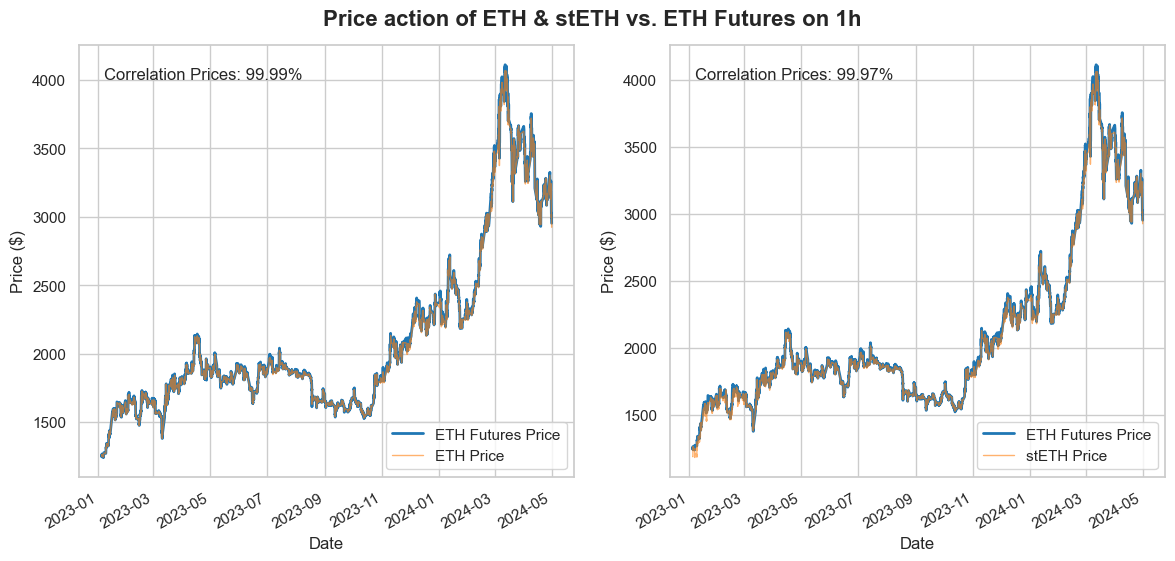

In [1754]:
show_price(df_cme_eth, df_cme_steth, corr_cme_eth_price, corr_cme_steth_price,  '1h')

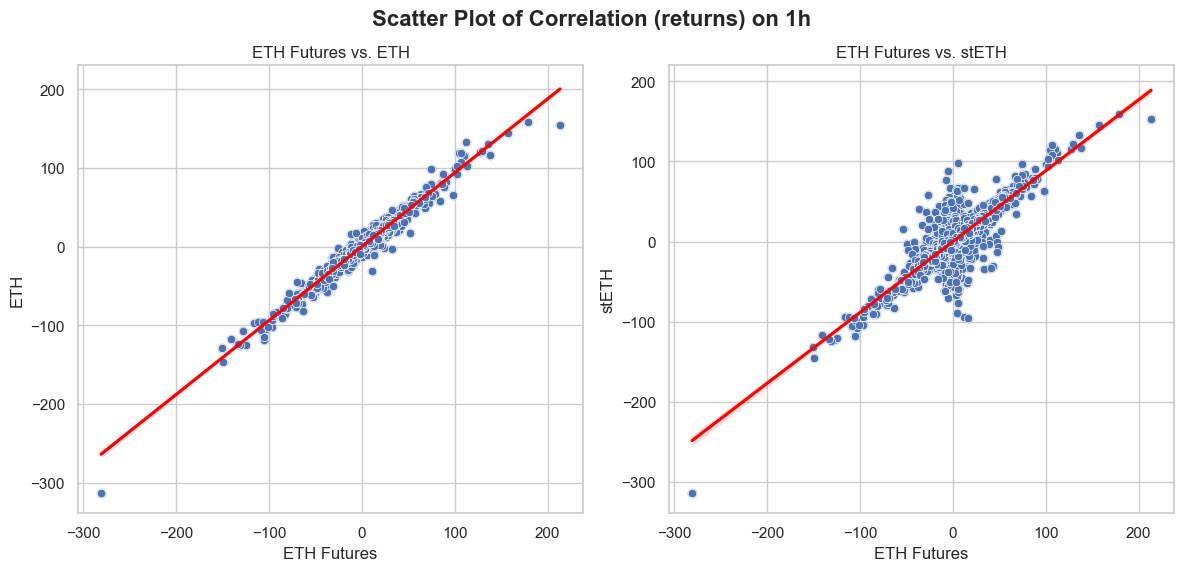

In [1755]:
show_scatters(df_cme_eth, df_cme_steth, '1h')

In [1756]:
# show outliers on stETH (typically related to high volatility)
outlier = df_cme_steth[abs((df_cme_steth[PRICE_CME_DELTA]) > 150) | (abs(df_cme_steth[PRICE_CME_DELTA]) > 150)]
outlier.head(10)

,Entry Date UTC,Price_cme,Price_steth,Price_cme_delta,Price_cme_return,Price_steth_delta,Price_steth_return,rolling_corr
4173,2024-02-25 23:00:00+00:00,3161.5,3099.06,213.5,0.072422,152.93,0.051909,0.981849
4294,2024-03-05 20:00:00+00:00,3440.0,3370.70,-281.0,-0.075517,-313.75,-0.085155,0.987968
4298,2024-03-06 05:00:00+00:00,3700.5,3642.66,157.0,0.044306,146.10,0.041784,0.987454
4395,2024-03-15 03:00:00+00:00,3751.0,3742.40,-151.0,-0.038698,-132.14,-0.034105,0.984479
4791,2024-04-28 22:00:00+00:00,3325.5,3303.02,179.5,0.057057,158.83,0.050515,0.994858


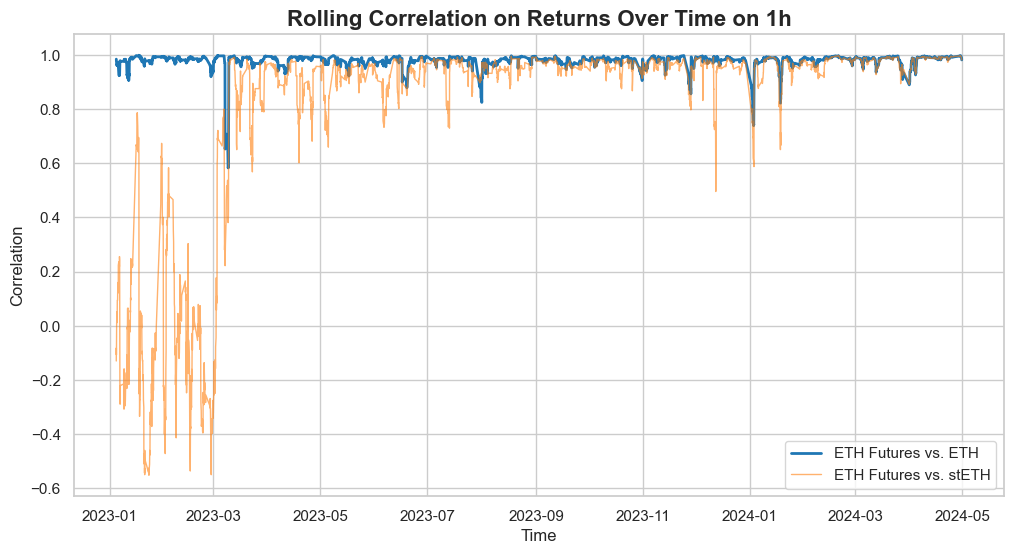

In [1757]:
show_rolling_correlations(df_cme_eth, df_cme_steth, '1h')

💡 ETH and stETH are generally highly correlated with ETH Futures, except for a notable dip in the correlation between ETH Futures and stETH in early 2023.

#### **Scenario 2**: Correlations on 1h timeframe [30.04.2023 to 30.04.2024]

In [1758]:
# Apply time filters
df_cme_eth_filtered = filter_period(df_cme_eth, '2023-04-30', '2024-04-30')
df_cme_steth_filtered = filter_period(df_cme_steth, '2023-04-30', '2024-04-30')

# Correlation on returns
corr_cme_eth_filtered_return = df_cme_eth_filtered[PRICE_CME_PCT].corr(df_cme_eth_filtered[PRICE_ETH_PCT])
corr_cme_steth_filtered_return = df_cme_steth_filtered[PRICE_CME_PCT].corr(df_cme_steth_filtered[PRICE_STETH_PCT])

# Correlation on prices
corr_cme_eth_filtered_price = df_cme_eth_filtered[PRICE_CME].corr(df_cme_eth_filtered[PRICE_ETH])
corr_cme_steth_filtered_price = df_cme_steth_filtered[PRICE_CME].corr(df_cme_steth_filtered[PRICE_STETH])

In [1759]:
show_correlations(
    corr_cme_eth_filtered_price,
    corr_cme_steth_filtered_price,
    corr_cme_eth_filtered_return,
    corr_cme_steth_filtered_return,
    '1h'
)

1h correlation on prices: 

	99.99% : eth futures vs. eth

	99.99% : eth futures vs. steth

1h correlation on returns: 

	98.13% : eth futures vs. eth

	96.35% : eth futures vs. steth


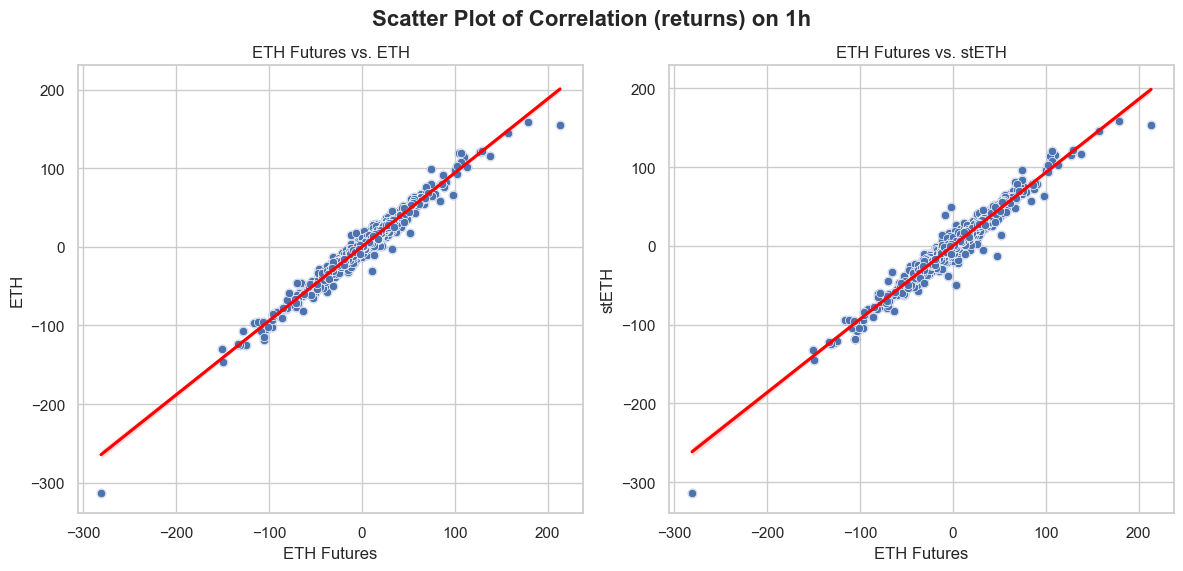

In [1760]:
show_scatters(df_cme_eth_filtered, df_cme_steth_filtered, '1h')

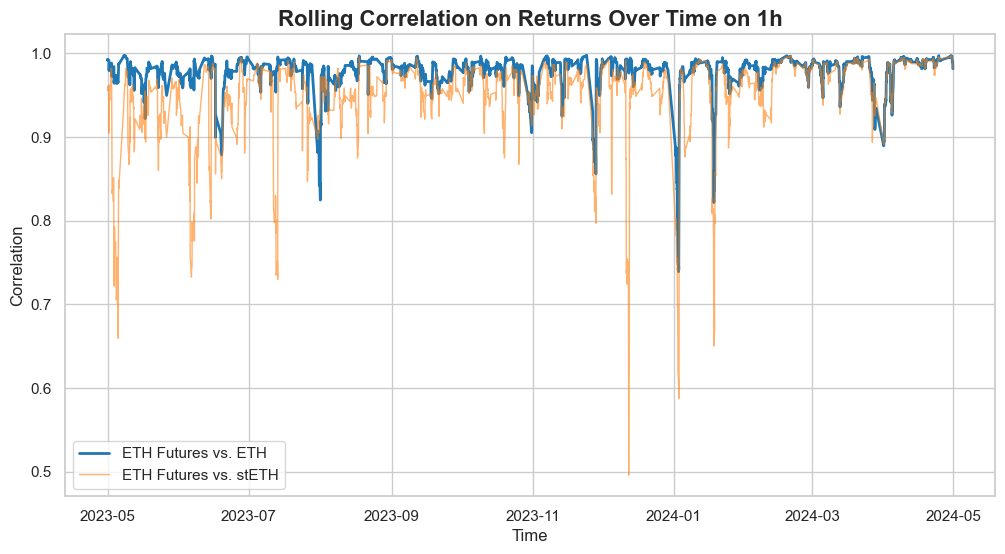

In [1761]:
df_cme_eth_filtered.reset_index(inplace=True)
df_cme_steth_filtered.reset_index(inplace=True)
show_rolling_correlations(df_cme_eth_filtered, df_cme_steth_filtered, '1h')

💡 Excluding early 2023, the charts shows a highly stable and strong correlation between ETH Futures and both ETH and stETH prices, consistently above 0.9. However, occasional sharp drops in the correlation with stETH (typically related to periods of high volatility in price) suggest transient divergences in how stETH reacts to market conditions compared to ETH Futures and spot ETH.

#### **Scenario 3**: Correlation on 5m timeframe [12.05.2024 - 12.06.2024]

In [1762]:
show_correlations(corr_cme_eth_5m_price, corr_cme_steth_5m_price, corr_cme_eth_5m_return,  corr_cme_steth_5m_return, '5m')

5m correlation on prices: 

	99.97% : eth futures vs. eth

	99.97% : eth futures vs. steth

5m correlation on returns: 

	97.40% : eth futures vs. eth

	97.41% : eth futures vs. steth


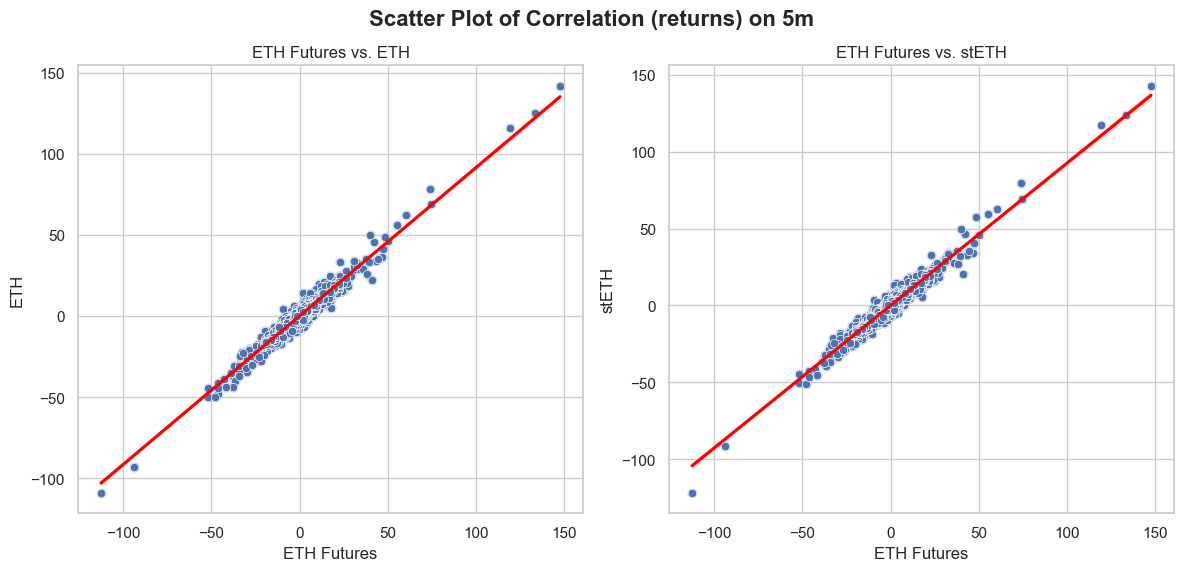

In [1763]:
show_scatters(df_cme_eth_5m, df_cme_steth_5m, '5m')

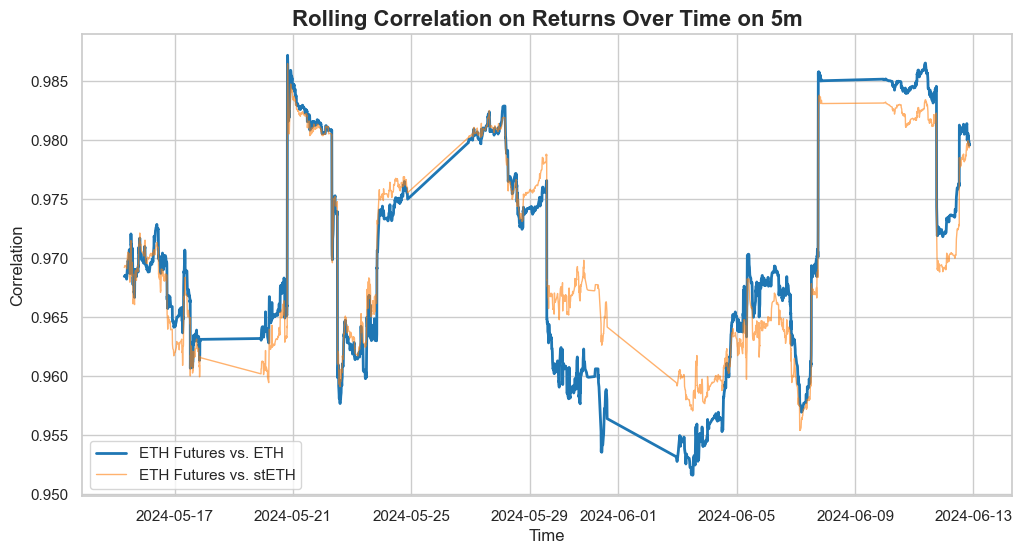

In [1764]:
show_rolling_correlations(df_cme_eth_5m, df_cme_steth_5m, '5m')

💡 Moving to a 5-minute timeframe results in a slightly lower correlation on returns, reflecting the increased data volatility at finer time scales. However, over the last month, both ETH and stETH display almost identical correlations in both price and returns.

Data Sourcing:
- `ETH` : Ethereum / USD @ Coinbase from [TradingView](https://www.tradingview.com/)
- `stETH` : STETHUSDT @ Bybit from [TradingView](https://www.tradingview.com/)
- `ETH Futures` : CME DataMine from [CME Group](https://datamine.cmegroup.com/)

Data Loads:
- See different [scripts](https://github.com/sjuanati/cme_eth_futures/tree/main/src) depending on the dataset.

Other remarks:
- We made some attempts to perform the same analysis using Dune's tables `prices.usd` and `dex.trades`, but prices showed significant lag vs. data on exchanges and correlations were significantly lower (92% on returns in scenario 1 for ETH vs. 98% using TradingView):
  -  [stETH-wstETH price dump](https://dune.com/queries/3775348)
  -  [ETH-stETH price dump](https://dune.com/queries/3751175)
  -  [wETH price dume](https://dune.com/queries/3818950)